# Model Exploration - Binary (ML50-2023)

## __Importing libraries__

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
import time 
import random


# Data imports
test = pd.read_csv('Data/test_cleaned.csv', index_col=0)
train = pd.read_csv('Data/train_cleaned.csv', index_col=0)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### __Small processing__

In [2]:
train = train.reset_index(drop=True).drop(columns=['c_patient'])
b_target = train['b_target']
c_target = train['c_target']
train = train.drop(columns=['b_target', 'c_target'])
test = test.drop(columns=['c_patient'])

In [3]:
cols_payer = [col for col in train.columns if col.startswith('b_payer_')]
cols_drop = ['b_admission_Elective', 'b_admission_Urgent',
                                               'b_race_Asian', 'b_race_Hispanic', 'b_race_Other',
                                               'b_source_Referral', 'b_source_Transfer', 'b_source_Unknown'] + cols_payer
train_light = train.drop(columns=cols_drop)
test_light = test.drop(columns=cols_drop)

cols_payer_group = [col for col in train.columns if col.startswith('b_payer_group_')]
train_heavy = train.drop(columns=cols_payer_group)
test_heavy = test.drop(columns=cols_payer_group)

## __To help with the models__

### __Feature Selection__

In [4]:
# Perform the RFE - no need for scaling (because the XGBClassifier is a tree-based model) and sampler (because we have the scale_pos_weight parameter)
estimator = XGBClassifier(scale_pos_weight=8, n_jobs=-1, random_state=42, n_estimators=300)
selector = RFE(estimator, n_features_to_select=10, step=1, verbose=1)
selector = selector.fit(train, b_target)
selector.support_

Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 fe

array([False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True])

In [5]:
# Lets plot the ranking of the features
ranking = selector.ranking_
features = train.columns
features_ranked = pd.DataFrame({'features': features, 'ranking': ranking})
features_ranked = features_ranked.sort_values(by='ranking', ascending=True)
features_ranked.reset_index(drop=True, inplace=True)
features_ranked.head(15)

,features,ranking
0,n_times_visited,1
1,n_invis,1
2,b_disp_transCare,1
3,b_disp_rehab,1
4,b_disp_disSNF,1
5,b_disp_disHospice,1
6,b_disp_disHome,1
7,b_weight,1
8,b_disp_disExpired,1
9,b_payer_No,1


In [6]:
# Create two datasets with the selected features
train_ultra_light = train[features_ranked['features'][:11]]
train_25 = train[features_ranked['features'][:25]]
test_ultra_light = test[features_ranked['features'][:11]]
test_25 = test[features_ranked['features'][:25]]
data_sets = {'train' : train, 'train_light' : train_light, 'train_25' : train_25, 'train_ultra_light' : train_ultra_light}

### __Functions__

In [7]:
def get_train_val(X_, y_, test_size=0.3, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, verbose=False, return_scaler=False):    
    X = X_.copy()
    y = y_.copy()
    numeric_cols = [col for col in X.columns if col.startswith('n_')]
    if scaler:
        X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
        
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    if sampler == 'simple': 
        print(f'Simple sampling with minority factor {minority_factor}') if verbose else None
        X_res = pd.concat([X_train, y_train], axis=1)
        minority_class = X_res[X_res[y.name] == 1]
        majority_class = X_res[X_res[y.name] == 0]
        # Using the resample function to upsample the minority class
        minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)

        upsampled = pd.concat([majority_class, minority_upsampled])
        X_train = upsampled.drop(columns=y.name)
        y_train = upsampled[y.name]
    # Using SMOTE to upsample the minority class, or other IMBLEARN samplers
    elif sampler:
        print('Using {} sampler'.format(sampler)) if verbose else None
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    if return_scaler:
        return X_train, X_val, y_train, y_val, scaler
    else:
        return X_train, X_val, y_train, y_val 

In [8]:
def test_model(model, X_, y_, just_score=False, scaler=MinMaxScaler(), test_size=0.3, sampler='simple', minority_factor=1, verbose=False, return_scaler=False, return_X=False): 
    X = X_.copy()
    y = y_.copy()
    
    if return_scaler:
        X_train, X_test, y_train, y_test, scaler = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    else:
        X_train, X_test, y_train, y_test = get_train_val(X_=X, y_=y, test_size=test_size, scaler=scaler, sampler=sampler, minority_factor=minority_factor, verbose=verbose, return_scaler=return_scaler)
    
    fit = model.fit(X_train, y_train)
    y_pred = fit.predict(X_test)
    if just_score:
        return fit, f1_score(y_test, y_pred)
    
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred))
    print('Recall: ', recall_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    if return_scaler and return_X:
        return fit, scaler, X_test, y_test
    elif return_scaler:
        return fit, scaler
    elif return_X:
        return fit, X_test, y_test
    else :
        return fit

In [9]:
def perform_random_search(X, y, model, params_dict, sampler=RandomOverSampler(), scaler=MinMaxScaler(), target='b_target'):
   # Create a pipeline
   pipeline = ImbPipeline([
       ('sampler', sampler),
       ('scaler', scaler),
       ('model', model)
   ])

   # Perform randomized search
   random_search = RandomizedSearchCV(pipeline, params_dict, cv=5, n_jobs=1, random_state=42, verbose=1, scoring='f1')
   random_search.fit(X, y)

   # Print the best parameters
   print("Best parameters: ", random_search.best_params_)

   # Return the best estimator
   return random_search.best_estimator_

In [18]:
def test_model_cv(X_, y_, model, scaler=MinMaxScaler(), params=None, sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1, return_train_score=False, return_std=False):
    X = X_.copy()
    y = y_.copy()
    # Lets program the cv manually so that we can track the progress
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    print(params) if (verbose and params) else None
    if params and n_jobs:
        model = model(**params, random_state=42, n_jobs=n_jobs)
    elif params:
        model = model(**params, random_state=42)
    scores_test, scores_train = [], []
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
        print(f'Starting fold {i+1}/{cv}...') if verbose else None
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        # Scale the data
        if scaler:
            numeric_cols = [col for col in X_train.columns if col.startswith('n_')]
            X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
            X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

        # Resample the data
        if sampler == 'simple':
            X_res = pd.concat([X_train, y_train], axis=1)
            minority_class = X_res[X_res[y.name] == 1]
            majority_class = X_res[X_res[y.name] == 0]
            # Using the resample function to upsample the minority class
            minority_upsampled = resample(minority_class, replace=True, n_samples=int(len(majority_class)*minority_factor), random_state=42)
            upsampled = pd.concat([majority_class, minority_upsampled])
            X_train = upsampled.drop(columns=y.name)
            y_train = upsampled[y.name]
        elif sampler:
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Score
        score_test = f1_score(y_test, y_pred)
        score_train = f1_score(y_train, model.predict(X_train))
        scores_test.append(score_test)
        scores_train.append(score_train)

        if score_greedy and score_test < score_greedy and i < 1:
            print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}. Stopping early...') if verbose else None
            return score_test

        print(f'Finished fold {i+1}/{cv}. Score train: {score_train}, score test: {score_test}') if verbose else None
    print(f'Average score: {np.mean(scores_test)} for params: {params}') if verbose else None
    if return_train_score and return_std:
        return np.mean(scores_test), np.std(scores_test), np.mean(scores_train), np.std(scores_train)
    elif return_train_score:
        return np.mean(scores_test), np.mean(scores_train)
    elif return_std:
        return np.mean(scores_test), np.std(scores_test)
    else:
        return np.mean(scores_test)
    

In [57]:
def random_search_manual(X_, y_, model, params, scaler, sampler='simple', iter=10, cv=5, scoring='f1', verbose=True, score_greedy=None, n_jobs=-1):
    X = X_.copy()
    y = y_.copy()
    # We will use the test_model_cv function to perform the random search
    best_score = 0
    best_params = None

    print(f'Doing {iter} iterations with {cv} folds, totally {iter*cv} fits...') if verbose else None
    for i in range(iter):
        print(f'Iteration {i+1}/{iter}...') if verbose else None
        params_ = {k : np.random.choice(v) for k, v in params.items() if k != 'hidden_layer_sizes'}
        if 'hidden_layer_sizes' in params:
            params_['hidden_layer_sizes'] = random.choice(params['hidden_layer_sizes'])
        score = test_model_cv(X_=X, y_=y, model=model, params=params_, scaler=scaler, sampler=sampler, minority_factor=1, cv=cv, scoring=scoring, verbose=verbose, score_greedy=score_greedy, n_jobs=n_jobs)
        if score > best_score:
            best_score = score
            best_params = params_
    
    print(f'Best score: {best_score} for params: {best_params}') if verbose else None
    return best_params

In [12]:
def test_datasets(list_datasets, y_, model, scaler=MinMaxScaler(), sampler='simple', minority_factor=1, cv=5, scoring='f1', verbose=True, verbose_cv=False):
    y = y_.copy()
    temp = {}
    cv_data = pd.DataFrame()
    for name, dataset in list_datasets.items():
        start = time.time()
        print(f'Testing dataset {name}...') if verbose else None

        # Cross validate the model
        a,b,c,d = test_model_cv(X_=dataset, y_=y, model=model, scaler=scaler, sampler=sampler, minority_factor=minority_factor, cv=cv, scoring=scoring, verbose=verbose_cv, return_train_score=True, return_std=True)
        a,b,c,d = round(a,4), round(b,4), round(c,4), round(d,4)

        # For the time count
        end = time.time()
        e = round(end-start, 2)
        temp[name] = [a,b,c,d,e]

    # Store the results in a dataframe
    cv_data = pd.DataFrame.from_dict(temp, orient='index', columns=['score_test', 'std_test', 'score_train', 'std_train', 'time'])
    return cv_data    

In [13]:
def submit (test, fit, scaler, cols_drop=None): 
    numerical_features = [col for col in train.columns if col.startswith('n_')]
    if cols_drop:
        X_test = test.drop(columns=cols_drop)
    else:
        X_test = test.copy()
    X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    y_pred = fit.predict(X_test)
    predictions = pd.DataFrame(y_pred, index=test.index, columns=['readmitted_binary'])
    predictions['readmitted_binary'].apply(lambda x: 'Yes' if x == 1 else 'No').to_csv('predictions.csv', header=True)

## __Models__

#### __Logistic Regression (0.327)__
- Ultra light dataframe seems to be the best option for this model, as it is the fastest by far and has an equivalent score to the train (large) dataframe

##### Vanilla

In [111]:
model = LogisticRegression(random_state=42, max_iter=1000)
logistic_stats = test_datasets(data_sets, b_target, model)
logistic_stats

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


#### __Random Forest Classifier (0.359)__
- Huge discrepancy between the train_ultra_light and the other datasets, becuase of the overfitting of the model to the larger datasets. The vanilla test doesn't seem to be such a good indicator of future performance of the other datasets.
- We set the min_samples_leaf to 10 so that we prevent the model from overfitting to the train dataset, so that we can compare the results of the different datasets.

In [33]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, min_samples_leaf=10)
rf_stats = test_datasets(data_sets, b_target, model, scaler=None)  # No scaler needed for RF
rf_stats

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3578,0.0065,0.8963,0.0020,26.10
train_light,0.3538,0.0064,0.8947,0.0015,21.52
train_25,0.3493,0.0061,0.8091,0.0016,15.77
train_ultra_light,0.3405,0.0027,0.7385,0.0023,9.69


##### Parameter tunning - Sampler from the own random tree

In [37]:
params_dict = {
  'n_estimators': [val for val in range(60, 300)],
  #'max_depth': [val for val in range(2, 25)],
  'min_samples_split': [val for val in range(2,15)],
  'min_samples_leaf': [val for val in range(2,15)],
  'max_features': ['sqrt', 'log2', None],
  'bootstrap': [True, False],
  'criterion': ['gini', 'entropy'],
  'class_weight': [None], # ['balanced_subsample', 'balanced']
}

best_estimator = random_search_manual(train,b_target, model=RandomForestClassifier, params=params_dict, 
                                      scaler=None, iter=50, sampler='simple', score_greedy=0.35, cv=5)

Doing 50 iterations with 5 folds, totally 250 fits...
Iteration 1/50...
{'n_estimators': 253, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.988893159487134, score test: 0.3044223517312307. Stopping early...
Iteration 2/50...
{'n_estimators': 138, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.9390858507880093, score test: 0.36156583629893235
Starting fold 2/5...
Finished fold 2/5. Score train: 0.9411034375727477, score test: 0.36107125777140125
Starting fold 3/5...
Finished fold 3/5. Score train: 0.9404662538579499, score test: 0.3500346340337105
Starting fold 4/5...
Finished fold 4/5. Score train: 0.9413959997667503, score test: 0.35660018993352327
Starting fold 5/5...
Finished fold 5/5. Score train: 0.9385

##### Double-checking if the train is still the best dataset

In [38]:
# Get the score of the best estimator
model = RandomForestClassifier(**{'n_estimators': 167, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini', 'class_weight': None})
rf_stats_optimized = test_datasets(data_sets, b_target, model)
rf_stats_optimized

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3586,0.0060,0.9232,0.0017,304.53
train_light,0.3552,0.0057,0.9209,0.0012,269.35
train_25,0.3496,0.0062,0.8209,0.0017,186.50
train_ultra_light,0.3408,0.0027,0.7385,0.0020,103.80


##### Feature Importances with the values obtained

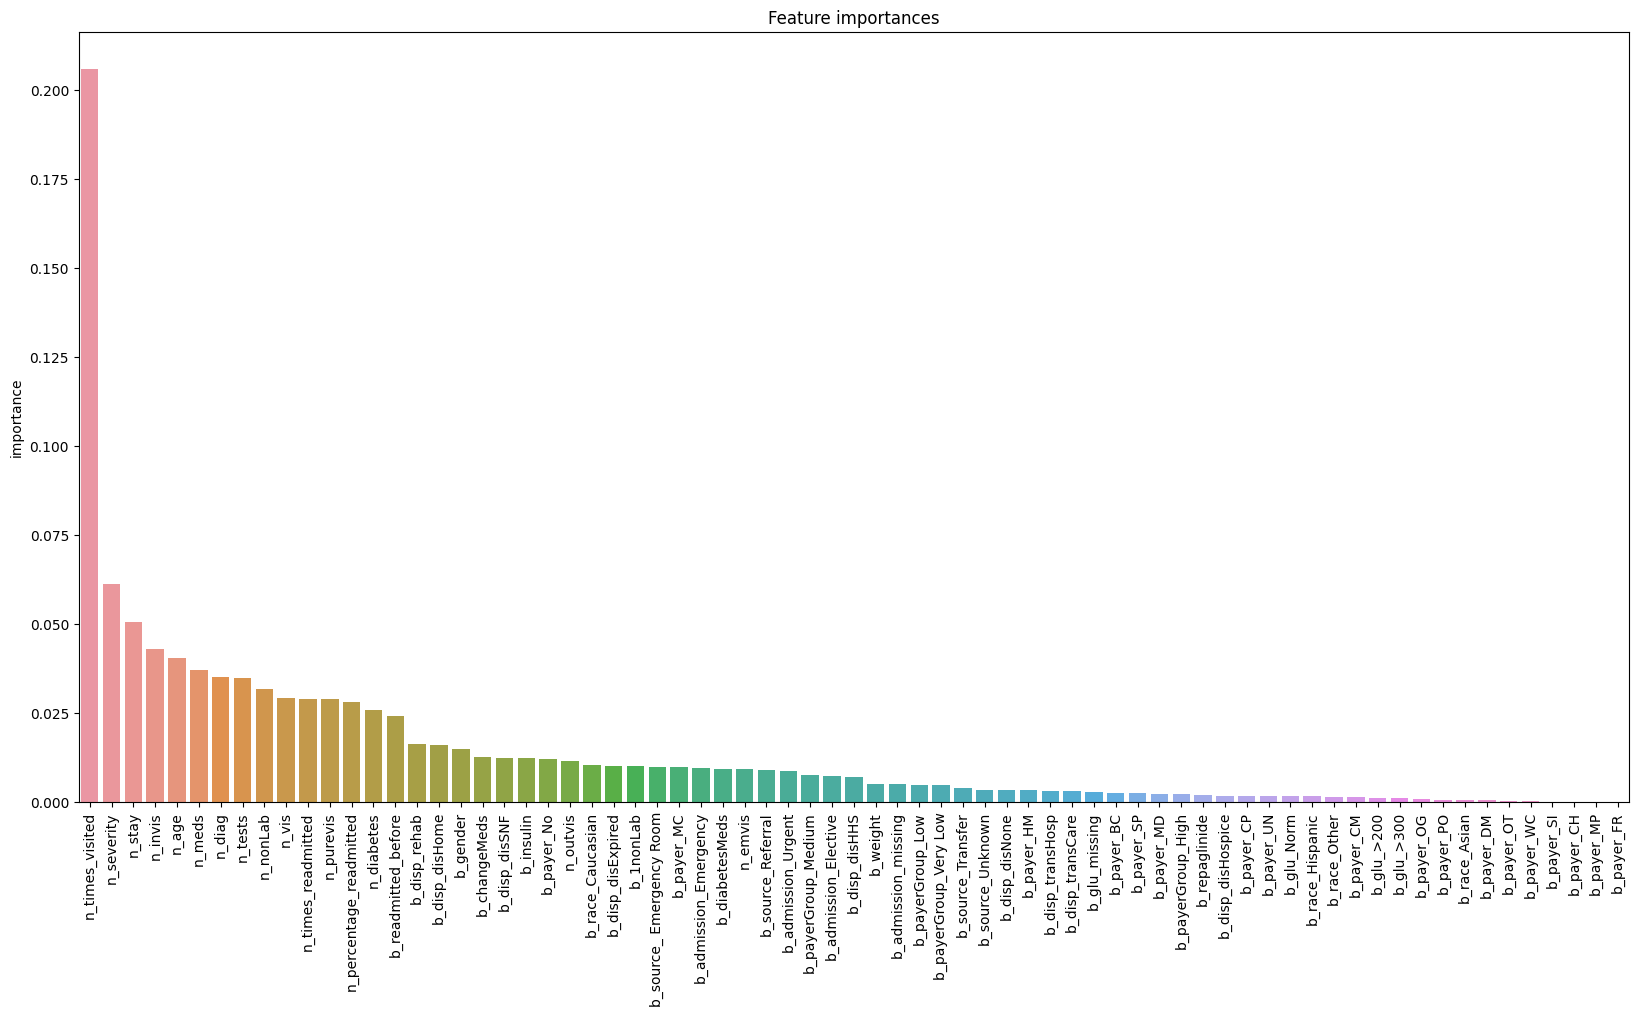

In [40]:
# Get the feature importances
fit_rf, _ = test_model(model, train, b_target, just_score=True)
feature_importances = pd.DataFrame(fit_rf.feature_importances_,
                                   index = train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.title('Feature importances')
plt.show()

#### __XGBoost Classifier (0.364)__
- Close call between the train and train_25 datasets. The train_25 takes less than half what the train takes, but it has a poorer score. Nevertheless it has 1/3 of the standard deviation of the train dataset, so it is a more stable model. We are going to value stability and time consumption in this case.

##### Vanilla Model

In [122]:
# Using vanilla XGBoost
model = XGBClassifier()
xgb_stats = test_datasets(data_sets, b_target, model)
xgb_stats

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3436,0.0062,0.8131,0.0019,5.95
train_light,0.3405,0.0052,0.8139,0.0028,4.57
train_25,0.3417,0.0013,0.7760,0.0031,3.35
train_ultra_light,0.3375,0.0041,0.7362,0.0020,2.82


##### Parameter tunning

In [ ]:
param_dict = {
    'n_estimators' : [val for val in range(50, 400,2)],
    'max_depth' : [val for val in range(2, 30)],
    'learning_rate' : [val for val in np.arange(0.01, 0.5, 0.01)],
    'gamma' : [val for val in np.arange(0, 1, 0.01)],
    'min_child_weight' : [val for val in range(1, 15)],
    'subsample' : [val for val in np.arange(0.5, 1, 0.01)],
    'colsample_bytree' : [val for val in np.arange(0.5, 1, 0.01)],
}

best_estimator = random_search_manual(train_25,b_target, model=XGBClassifier, params=param_dict, sampler='simple', scaler=MinMaxScaler(), iter=100, score_greedy=0.35, cv=5)

- Some manual tweaking was done to the parameters after the optimization, so that it could be possible to find a better model (local optimum). By manual tweaking we mean that we tried to find a better model by changing the parameters by hand one by one, using a greedy approach, which implies that we go in the other direction (or stop) whenever we dont see an improvement in the score.
-  Train_25 seems to get worse results than the train full dataset, so it was decided to use the full dataset for the submission.

In [38]:
model = XGBClassifier(n_estimators=390, max_depth=16, learning_rate=0.0060, gamma=0.23, min_child_weight=5, subsample=0.60, colsample_bytree=0.51)
fit_xgb, scaler_xgb = test_model(model, train, b_target, test_size=0.3, sampler='simple', return_scaler=True, scaler=MinMaxScaler())

Accuracy:  0.8039775386055218
Precision:  0.28534031413612565
Recall:  0.5027253668763103
F1:  0.3640504023075755
Confusion matrix: 
 [[15982  3003]
 [ 1186  1199]]
Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.84      0.88     18985
         1.0       0.29      0.50      0.36      2385

    accuracy                           0.80     21370
   macro avg       0.61      0.67      0.62     21370
weighted avg       0.86      0.80      0.83     21370



In [219]:
test = test[fit_xgb.get_booster().feature_names]
submit(test, fit_xgb, scaler_xgb)

#### __MPL Classifier (0.345)__
- A clear winner in the vanilla dataset test was the train_ultra_light for its relatively low training time and for the best score (least overfitting)
- It is impossible to do the model tunning for the train, train_light and train_25, as it would take too long. 

##### Vanilla Model

In [123]:
# Vanilla MLP
model = MLPClassifier(max_iter=500, random_state=42)
mlp_stats = test_datasets(data_sets, b_target, model)
mlp_stats

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.2950,0.0030,0.8441,0.0055,1161.55
train_light,0.2981,0.0045,0.8098,0.0169,1032.04
train_25,0.3287,0.0079,0.7541,0.0095,980.62
train_ultra_light,0.3408,0.0044,0.7274,0.0046,269.34


##### Model tunning

In [ ]:
param_dict = {
    'hidden_layer_sizes': [(5,5), (5,5,5), (10,10,10), (50), (100), (50, 50), (100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'batch_size': [200, 8, 16, 32, 64, 128, 256, 512],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'power_t': [0.5, 0.6, 0.7],
    'max_iter': [500],
    'verbose' : [True],
    'shuffle': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'warm_start': [False, True],
    'momentum': [0.9, 0.95, 0.99],
    'nesterovs_momentum': [True, False],
    'early_stopping': [False, True],
    'validation_fraction': [0.1, 0.2, 0.3],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.999, 0.995, 0.99],
    'epsilon': [1e-8, 1e-7, 1e-6],
    'n_iter_no_change': [5, 10, 15]
}

best_estimator = random_search_manual(train_ultra_light, b_target, model=MLPClassifier, params=param_dict, sampler='simple', scaler=MinMaxScaler(), iter=100, score_greedy=0.335, cv=4, n_jobs=None)

In [51]:
model = MLPClassifier(**{'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.001, 'batch_size': 32, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'power_t': 0.6, 'max_iter': 500, 'verbose': True, 'shuffle': True, 'tol': 0.01, 'warm_start': False, 'momentum': 0.99, 'nesterovs_momentum': True, 'early_stopping': True, 'validation_fraction': 0.2, 'beta_1': 0.99, 'beta_2': 0.999, 'epsilon': 1e-07, 'n_iter_no_change': 15, 'hidden_layer_sizes': (10, 10, 10)})
mlp_stats_optimized = test_datasets(data_sets, b_target, model)
mlp_stats_optimized

,score_test,std_test,score_train,std_train,time
train,0.3279,0.0058,0.7455,0.0124,288.42
train_light,0.3309,0.0044,0.7453,0.0047,407.03
train_25,0.3410,0.0064,0.7340,0.0051,388.98
train_ultra_light,0.3445,0.0071,0.7238,0.0056,384.19


#### __ADA Boost (0.328)__
- Using the train_25 for the ada boost model, as the training time is close to the train_ultra_light and the score is better. 
- The train dataset achieves a higher test result, but it takes more than double the time and has a standard deviation higher than the train_25

##### Vanilla Model

In [124]:
# Using the vanilla ADABoost
model = AdaBoostClassifier()
ada_stats = test_datasets(data_sets, b_target, model)
ada_stats

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3267,0.0040,0.6944,0.0016,43.50
train_light,0.3250,0.0027,0.6957,0.0016,33.01
train_25,0.3262,0.0034,0.6947,0.0017,20.87
train_ultra_light,0.3245,0.0034,0.6959,0.0027,12.29


##### Model tunning

In [63]:
params_dict = {
    # For ada boost
    'n_estimators': [val for val in range(50, 300,2)],
    'learning_rate': [val for val in np.arange(0.01, 2, 0.05)],
    'algorithm': ['SAMME', 'SAMME.R'],
}

best_estimator = random_search_manual(train_25, b_target, model=AdaBoostClassifier, params=params_dict, sampler='simple', scaler=MinMaxScaler(), iter=100, score_greedy=0.33, cv=5, n_jobs=None)

Doing 100 iterations with 5 folds, totally 500 fits...
Iteration 1/100...
{'n_estimators': 144, 'learning_rate': 1.7100000000000002, 'algorithm': 'SAMME'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.6919225503618228, score test: 0.3277611940298507. Stopping early...
Iteration 2/100...
{'n_estimators': 266, 'learning_rate': 0.51, 'algorithm': 'SAMME.R'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.693853312824906, score test: 0.3274715531254618. Stopping early...
Iteration 3/100...
{'n_estimators': 82, 'learning_rate': 1.81, 'algorithm': 'SAMME.R'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.6943958898685647, score test: 0.32609953703703703. Stopping early...
Iteration 4/100...
{'n_estimators': 60, 'learning_rate': 1.06, 'algorithm': 'SAMME'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.693936928745753, score test: 0.32149901380670615. Stopping early...
Iteration 5/100...
{'n_estimators': 202, 'learning_rate': 1.9100000000000001, 'algorithm': 'S

In [64]:
model = AdaBoostClassifier(**{'n_estimators': 144, 'learning_rate': 1.4600000000000002, 'algorithm': 'SAMME.R'})
ada_stats_optimized = test_datasets(data_sets, b_target, model)
ada_stats_optimized

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3276,0.0043,0.6951,0.0027,123.76
train_light,0.3269,0.0039,0.6945,0.0015,93.59
train_25,0.3277,0.0043,0.6947,0.0015,57.77
train_ultra_light,0.3259,0.0032,0.6960,0.0023,36.79


#### __Gradient Boosting Classifier (0.343)__
- The winner is the train_ultra_light dataset, as it has the lowest standard deviation and is very close to the other datasets in terms of score. It is also by far the fastest to run.
- We could also consider the train_25 dataset, as it has a better score than the train_ultra_light dataset and is also very fast to run.

##### Vanilla Model

In [14]:
model = GradientBoostingClassifier(random_state=42)
gb_stats = test_datasets(data_sets, b_target, model)
gb_stats

Testing dataset train...


Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3369,0.0028,0.7319,0.0017,195.20
train_light,0.3374,0.0043,0.7289,0.0015,156.70
train_25,0.3372,0.0033,0.7295,0.0010,83.96
train_ultra_light,0.3367,0.0024,0.7252,0.0010,46.18


##### Model tunning

In [68]:
# For the gradient boosting
params_dict = {
    'n_estimators': [val for val in range(50, 300,2)],
    'learning_rate': [val for val in np.arange(0.01, 2, 0.05)],
    'max_depth': [val for val in range(2, 30)],
    'min_samples_split': [val for val in range(2,15)],
    'min_samples_leaf': [val for val in range(2,15)],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse'],
    'subsample': [val for val in np.arange(0.5, 1, 0.01)],
    'loss': ['exponential', 'log_loss']
}

best_estimator = random_search_manual(train_ultra_light, b_target, model=GradientBoostingClassifier, params=params_dict, sampler='simple', scaler=MinMaxScaler(), iter=50, score_greedy=0.33, cv=5, n_jobs=None)

Doing 50 iterations with 5 folds, totally 250 fits...
Iteration 1/50...
{'n_estimators': 226, 'learning_rate': 0.21000000000000002, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'friedman_mse', 'subsample': 0.56, 'loss': 'exponential'}
Starting fold 1/5...
Finished fold 1/5. Score train: 0.7446949538420157, score test: 0.3321981424148607
Starting fold 2/5...
Finished fold 2/5. Score train: 0.7426714495101442, score test: 0.33498913380937595
Starting fold 3/5...
Finished fold 3/5. Score train: 0.74518830879935, score test: 0.32595824244312865
Starting fold 4/5...
Finished fold 4/5. Score train: 0.7421618727794812, score test: 0.3335998720614105
Starting fold 5/5...
Finished fold 5/5. Score train: 0.7478176902278872, score test: 0.32915057915057916
Average score: 0.331179193975871 for params: {'n_estimators': 226, 'learning_rate': 0.21000000000000002, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2

Check the best model

In [69]:
model = GradientBoostingClassifier(**{'n_estimators': 250, 'learning_rate': 0.51, 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'criterion': 'squared_error', 'subsample': 0.9300000000000004, 'loss': 'log_loss'})
gb_stats_optimized = test_datasets(data_sets, b_target, model)
gb_stats_optimized

Testing dataset train...
Testing dataset train_light...
Testing dataset train_25...
Testing dataset train_ultra_light...


,score_test,std_test,score_train,std_train,time
train,0.3403,0.0055,0.7301,0.0036,37.27
train_light,0.3377,0.0065,0.7287,0.0040,33.70
train_25,0.3434,0.0037,0.7280,0.0016,28.96
train_ultra_light,0.3415,0.0040,0.7250,0.0010,24.50


## __Conclusion__